## Simple Feed Forward Neural Network
- Try simple one first, then move to complex one

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss Function
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

# Forward Propagation
def forward_propagation(X, weights, biases):
    activations = [X]
    z_values = []
    for w, b in zip(weights, biases):
        z = np.dot(activations[-1], w) + b
        z_values.append(z)
        if w is not weights[-1]:  # For hidden layers
            activations.append(sigmoid(z))
        else:  # For output layer
            activations.append(softmax(z))
    return activations, z_values

# Backward Propagation
def backward_propagation(y_true, activations, z_values, weights):
    gradients_w = []
    gradients_b = []
    m = y_true.shape[0]
    dz = activations[-1] - y_true  # Output layer delta

    for i in reversed(range(len(weights))):
        dw = np.dot(activations[i].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)

        if i != 0:  # Skip for input layer
            dz = np.dot(dz, weights[i].T) * sigmoid_derivative(activations[i])

    return gradients_w, gradients_b

# Initialize Weights and Biases
def initialize_network(input_size, hidden_layers, output_size):
    layers = [input_size] + hidden_layers + [output_size]
    weights = [np.random.randn(layers[i], layers[i+1]) * 0.01 for i in range(len(layers)-1)]
    biases = [np.zeros((1, layer)) for layer in layers[1:]]
    return weights, biases

# Training Function
def train_network(X_train, y_train, X_val, y_val, input_size, hidden_layers, output_size, epochs, learning_rate):
    weights, biases = initialize_network(input_size, hidden_layers, output_size)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Forward Propagation
        activations, z_values = forward_propagation(X_train, weights, biases)

        # Compute Loss
        train_loss = cross_entropy_loss(y_train, activations[-1])
        train_losses.append(train_loss)

        # Backward Propagation
        gradients_w, gradients_b = backward_propagation(y_train, activations, z_values, weights)

        # Update Weights and Biases
        for i in range(len(weights)):
            weights[i] -= learning_rate * gradients_w[i]
            biases[i] -= learning_rate * gradients_b[i]

        # Validation Loss
        val_activations, _ = forward_propagation(X_val, weights, biases)
        val_loss = cross_entropy_loss(y_val, val_activations[-1])
        val_losses.append(val_loss)

        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    return weights, biases, train_losses, val_losses

# Evaluation Function
def evaluate_model(X_test, y_test, weights, biases):
    activations, _ = forward_propagation(X_test, weights, biases)
    y_pred = np.argmax(activations[-1], axis=1)
    y_true = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, conf_matrix


Epoch 1/50 - Train Loss: 2.3040 - Val Loss: 2.3025
Epoch 11/50 - Train Loss: 2.3012 - Val Loss: 2.3014
Epoch 21/50 - Train Loss: 2.3011 - Val Loss: 2.3015
Epoch 31/50 - Train Loss: 2.3011 - Val Loss: 2.3015
Epoch 41/50 - Train Loss: 2.3011 - Val Loss: 2.3015
Epoch 50/50 - Train Loss: 2.3011 - Val Loss: 2.3015
Test Accuracy: 0.1135
Confusion Matrix:
[[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]


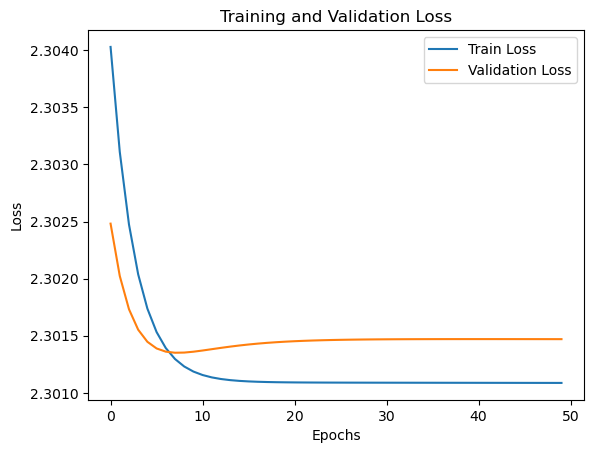

In [4]:
if __name__ == "__main__":
    # Load MNIST Dataset using torchvision
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

    # Convert to numpy arrays
    X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
    y_train = train_dataset.targets.numpy().reshape(-1, 1)

    X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
    y_test = test_dataset.targets.numpy().reshape(-1, 1)

    # One-Hot Encode Labels
    # encoder = OneHotEncoder(sparse=False)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)

    # Split Training and Validation Data
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

    # Hyperparameters
    input_size = X_train.shape[1]
    hidden_layers = [128, 64]  # Two hidden layers with 128 and 64 neurons
    output_size = y_train.shape[1]
    epochs = 50
    learning_rate = 0.1

    # Train the Network
    weights, biases, train_losses, val_losses = train_network(
        X_train, y_train, X_val, y_val, input_size, hidden_layers, output_size, epochs, learning_rate
    )

    # Evaluate the Network
    accuracy, conf_matrix = evaluate_model(X_test, y_test_encoded, weights, biases)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Losses
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

## Complex Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

Using device: cpu


Epoch 1/100: 100%|██████████| 375/375 [00:30<00:00, 12.44it/s, train_loss=4.6715]


Epoch 1/100:
Average Train Loss: 6.3772
Average Val Loss: 1.8659
Validation Accuracy: 58.08%


Epoch 2/100: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s, train_loss=3.3501]


Epoch 2/100:
Average Train Loss: 4.1964
Average Val Loss: 1.4904
Validation Accuracy: 66.84%


Epoch 3/100: 100%|██████████| 375/375 [00:28<00:00, 13.33it/s, train_loss=2.8172]


Epoch 3/100:
Average Train Loss: 3.2466
Average Val Loss: 1.1720
Validation Accuracy: 72.92%


Epoch 4/100: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s, train_loss=2.2363]


Epoch 4/100:
Average Train Loss: 2.5263
Average Val Loss: 0.8779
Validation Accuracy: 77.70%


Epoch 5/100: 100%|██████████| 375/375 [00:28<00:00, 13.39it/s, train_loss=1.4897]


Epoch 5/100:
Average Train Loss: 1.9257
Average Val Loss: 0.6887
Validation Accuracy: 80.83%


Epoch 6/100: 100%|██████████| 375/375 [00:27<00:00, 13.44it/s, train_loss=1.0601]


Epoch 6/100:
Average Train Loss: 1.4448
Average Val Loss: 0.5529
Validation Accuracy: 83.72%


Epoch 7/100: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s, train_loss=1.2300]


Epoch 7/100:
Average Train Loss: 1.0817
Average Val Loss: 0.4624
Validation Accuracy: 85.60%


Epoch 8/100: 100%|██████████| 375/375 [00:27<00:00, 13.56it/s, train_loss=0.8912]


Epoch 8/100:
Average Train Loss: 0.8535
Average Val Loss: 0.3949
Validation Accuracy: 87.56%


Epoch 9/100: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s, train_loss=0.6186]


Epoch 9/100:
Average Train Loss: 0.6910
Average Val Loss: 0.3296
Validation Accuracy: 89.83%


Epoch 10/100: 100%|██████████| 375/375 [00:27<00:00, 13.48it/s, train_loss=0.4146]


Epoch 10/100:
Average Train Loss: 0.5681
Average Val Loss: 0.2874
Validation Accuracy: 91.15%


Epoch 11/100: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s, train_loss=0.6205]


Epoch 11/100:
Average Train Loss: 0.4769
Average Val Loss: 0.2569
Validation Accuracy: 92.12%


Epoch 12/100: 100%|██████████| 375/375 [00:29<00:00, 12.74it/s, train_loss=0.4910]


Epoch 12/100:
Average Train Loss: 0.4239
Average Val Loss: 0.2150
Validation Accuracy: 93.18%


Epoch 13/100: 100%|██████████| 375/375 [00:29<00:00, 12.76it/s, train_loss=0.4762]


Epoch 13/100:
Average Train Loss: 0.3766
Average Val Loss: 0.1954
Validation Accuracy: 93.66%


Epoch 14/100: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s, train_loss=0.4205]


Epoch 14/100:
Average Train Loss: 0.3312
Average Val Loss: 0.1792
Validation Accuracy: 94.45%


Epoch 15/100: 100%|██████████| 375/375 [00:28<00:00, 12.93it/s, train_loss=0.3203]


Epoch 15/100:
Average Train Loss: 0.3041
Average Val Loss: 0.1703
Validation Accuracy: 94.67%


Epoch 16/100: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s, train_loss=0.3180]


Epoch 16/100:
Average Train Loss: 0.2749
Average Val Loss: 0.1558
Validation Accuracy: 94.97%


Epoch 17/100: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s, train_loss=0.3032]


Epoch 17/100:
Average Train Loss: 0.2572
Average Val Loss: 0.1515
Validation Accuracy: 94.97%


Epoch 18/100: 100%|██████████| 375/375 [00:28<00:00, 12.98it/s, train_loss=0.2531]


Epoch 18/100:
Average Train Loss: 0.2446
Average Val Loss: 0.1334
Validation Accuracy: 95.81%


Epoch 19/100: 100%|██████████| 375/375 [00:28<00:00, 13.02it/s, train_loss=0.3112]


Epoch 19/100:
Average Train Loss: 0.2372
Average Val Loss: 0.1340
Validation Accuracy: 95.85%


Epoch 20/100: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s, train_loss=0.2591]


Epoch 20/100:
Average Train Loss: 0.2189
Average Val Loss: 0.1184
Validation Accuracy: 96.36%


Epoch 21/100: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s, train_loss=0.1610]


Epoch 21/100:
Average Train Loss: 0.2080
Average Val Loss: 0.1220
Validation Accuracy: 96.17%


Epoch 22/100: 100%|██████████| 375/375 [00:30<00:00, 12.44it/s, train_loss=0.2137]


Epoch 22/100:
Average Train Loss: 0.2030
Average Val Loss: 0.1188
Validation Accuracy: 96.22%


Epoch 23/100: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s, train_loss=0.1729]


Epoch 23/100:
Average Train Loss: 0.1888
Average Val Loss: 0.1100
Validation Accuracy: 96.50%


Epoch 24/100: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s, train_loss=0.0826]


Epoch 24/100:
Average Train Loss: 0.1834
Average Val Loss: 0.1088
Validation Accuracy: 96.62%


Epoch 25/100: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s, train_loss=0.1954]


Epoch 25/100:
Average Train Loss: 0.1762
Average Val Loss: 0.1021
Validation Accuracy: 96.81%


Epoch 26/100: 100%|██████████| 375/375 [00:28<00:00, 13.02it/s, train_loss=0.2857]


Epoch 26/100:
Average Train Loss: 0.1736
Average Val Loss: 0.0984
Validation Accuracy: 97.06%


Epoch 27/100: 100%|██████████| 375/375 [00:29<00:00, 12.78it/s, train_loss=0.1204]


Epoch 27/100:
Average Train Loss: 0.1643
Average Val Loss: 0.1047
Validation Accuracy: 96.72%


Epoch 28/100: 100%|██████████| 375/375 [00:28<00:00, 13.12it/s, train_loss=0.1934]


Epoch 28/100:
Average Train Loss: 0.1609
Average Val Loss: 0.0975
Validation Accuracy: 96.97%


Epoch 29/100: 100%|██████████| 375/375 [00:28<00:00, 12.98it/s, train_loss=0.3817]


Epoch 29/100:
Average Train Loss: 0.1575
Average Val Loss: 0.0961
Validation Accuracy: 96.99%


Epoch 30/100: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s, train_loss=0.1934]


Epoch 30/100:
Average Train Loss: 0.1537
Average Val Loss: 0.0850
Validation Accuracy: 97.37%


Epoch 31/100: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s, train_loss=0.1802]


Epoch 31/100:
Average Train Loss: 0.1411
Average Val Loss: 0.0921
Validation Accuracy: 97.21%


Epoch 32/100: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s, train_loss=0.1918]


Epoch 32/100:
Average Train Loss: 0.1380
Average Val Loss: 0.0887
Validation Accuracy: 97.24%


Epoch 33/100: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s, train_loss=0.1905]


Epoch 33/100:
Average Train Loss: 0.1357
Average Val Loss: 0.0797
Validation Accuracy: 97.60%


Epoch 34/100: 100%|██████████| 375/375 [00:28<00:00, 13.11it/s, train_loss=0.0598]


Epoch 34/100:
Average Train Loss: 0.1332
Average Val Loss: 0.0827
Validation Accuracy: 97.38%


Epoch 35/100: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s, train_loss=0.1655]


Epoch 35/100:
Average Train Loss: 0.1274
Average Val Loss: 0.0788
Validation Accuracy: 97.58%


Epoch 36/100: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s, train_loss=0.1356]


Epoch 36/100:
Average Train Loss: 0.1268
Average Val Loss: 0.0768
Validation Accuracy: 97.56%


Epoch 37/100: 100%|██████████| 375/375 [00:28<00:00, 13.12it/s, train_loss=0.2317]


Epoch 37/100:
Average Train Loss: 0.1227
Average Val Loss: 0.0750
Validation Accuracy: 97.75%


Epoch 38/100: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s, train_loss=0.8277]


Epoch 38/100:
Average Train Loss: 0.1187
Average Val Loss: 0.0790
Validation Accuracy: 97.36%


Epoch 39/100: 100%|██████████| 375/375 [00:29<00:00, 12.85it/s, train_loss=0.1115]


Epoch 39/100:
Average Train Loss: 0.1218
Average Val Loss: 0.0675
Validation Accuracy: 97.96%


Epoch 40/100: 100%|██████████| 375/375 [00:28<00:00, 13.07it/s, train_loss=0.1182]


Epoch 40/100:
Average Train Loss: 0.1145
Average Val Loss: 0.0648
Validation Accuracy: 98.03%


Epoch 41/100: 100%|██████████| 375/375 [00:29<00:00, 12.88it/s, train_loss=0.0943]


Epoch 41/100:
Average Train Loss: 0.1083
Average Val Loss: 0.0629
Validation Accuracy: 97.98%


Epoch 42/100: 100%|██████████| 375/375 [00:29<00:00, 12.58it/s, train_loss=0.1267]


Epoch 42/100:
Average Train Loss: 0.1095
Average Val Loss: 0.0649
Validation Accuracy: 97.91%


Epoch 43/100: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s, train_loss=0.0910]


Epoch 43/100:
Average Train Loss: 0.1073
Average Val Loss: 0.0600
Validation Accuracy: 98.19%


Epoch 44/100: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s, train_loss=0.2040]


Epoch 44/100:
Average Train Loss: 0.1012
Average Val Loss: 0.0611
Validation Accuracy: 98.01%


Epoch 45/100: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s, train_loss=0.0548]


Epoch 45/100:
Average Train Loss: 0.1001
Average Val Loss: 0.0611
Validation Accuracy: 98.04%


Epoch 46/100: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s, train_loss=0.0479]


Epoch 46/100:
Average Train Loss: 0.1026
Average Val Loss: 0.0614
Validation Accuracy: 98.07%


Epoch 47/100: 100%|██████████| 375/375 [00:29<00:00, 12.93it/s, train_loss=0.0605]


Epoch 47/100:
Average Train Loss: 0.0979
Average Val Loss: 0.0590
Validation Accuracy: 98.12%


Epoch 48/100: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s, train_loss=0.0886]


Epoch 48/100:
Average Train Loss: 0.0951
Average Val Loss: 0.0644
Validation Accuracy: 98.02%


Epoch 49/100: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s, train_loss=0.0702]


Epoch 49/100:
Average Train Loss: 0.0926
Average Val Loss: 0.0564
Validation Accuracy: 98.07%


Epoch 50/100: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s, train_loss=0.1215]


Epoch 50/100:
Average Train Loss: 0.0887
Average Val Loss: 0.0603
Validation Accuracy: 98.16%


Epoch 51/100: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s, train_loss=0.0837]


Epoch 51/100:
Average Train Loss: 0.0920
Average Val Loss: 0.0578
Validation Accuracy: 98.20%


Epoch 52/100: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s, train_loss=0.2005]


Epoch 52/100:
Average Train Loss: 0.0853
Average Val Loss: 0.0549
Validation Accuracy: 98.28%


Epoch 53/100: 100%|██████████| 375/375 [00:28<00:00, 13.08it/s, train_loss=0.0273]


Epoch 53/100:
Average Train Loss: 0.0882
Average Val Loss: 0.0549
Validation Accuracy: 98.24%


Epoch 54/100: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s, train_loss=0.0412]


Epoch 54/100:
Average Train Loss: 0.0873
Average Val Loss: 0.0511
Validation Accuracy: 98.37%


Epoch 55/100: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s, train_loss=0.0454]


Epoch 55/100:
Average Train Loss: 0.0840
Average Val Loss: 0.0548
Validation Accuracy: 98.35%


Epoch 56/100: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s, train_loss=0.0508]


Epoch 56/100:
Average Train Loss: 0.0835
Average Val Loss: 0.0557
Validation Accuracy: 98.23%


Epoch 57/100: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s, train_loss=0.0641]


Epoch 57/100:
Average Train Loss: 0.0791
Average Val Loss: 0.0535
Validation Accuracy: 98.28%


Epoch 58/100: 100%|██████████| 375/375 [00:30<00:00, 12.30it/s, train_loss=0.0685]


Epoch 58/100:
Average Train Loss: 0.0768
Average Val Loss: 0.0560
Validation Accuracy: 98.28%


Epoch 59/100: 100%|██████████| 375/375 [00:30<00:00, 12.36it/s, train_loss=0.0830]


Epoch 59/100:
Average Train Loss: 0.0763
Average Val Loss: 0.0499
Validation Accuracy: 98.47%


Epoch 60/100: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s, train_loss=0.0447]


Epoch 60/100:
Average Train Loss: 0.0751
Average Val Loss: 0.0525
Validation Accuracy: 98.38%


Epoch 61/100: 100%|██████████| 375/375 [00:31<00:00, 12.09it/s, train_loss=0.0561]


Epoch 61/100:
Average Train Loss: 0.0722
Average Val Loss: 0.0516
Validation Accuracy: 98.41%


Epoch 62/100: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s, train_loss=0.1125]


Epoch 62/100:
Average Train Loss: 0.0740
Average Val Loss: 0.0522
Validation Accuracy: 98.34%


Epoch 63/100: 100%|██████████| 375/375 [00:30<00:00, 12.34it/s, train_loss=0.0929]


Epoch 63/100:
Average Train Loss: 0.0712
Average Val Loss: 0.0458
Validation Accuracy: 98.60%


Epoch 64/100: 100%|██████████| 375/375 [00:31<00:00, 11.81it/s, train_loss=0.0579]


Epoch 64/100:
Average Train Loss: 0.0687
Average Val Loss: 0.0500
Validation Accuracy: 98.53%


Epoch 65/100: 100%|██████████| 375/375 [00:29<00:00, 12.71it/s, train_loss=0.0795]


Epoch 65/100:
Average Train Loss: 0.0674
Average Val Loss: 0.0427
Validation Accuracy: 98.83%


Epoch 66/100: 100%|██████████| 375/375 [00:29<00:00, 12.54it/s, train_loss=0.1277]


Epoch 66/100:
Average Train Loss: 0.0673
Average Val Loss: 0.0469
Validation Accuracy: 98.68%


Epoch 67/100: 100%|██████████| 375/375 [00:29<00:00, 12.66it/s, train_loss=0.0391]


Epoch 67/100:
Average Train Loss: 0.0646
Average Val Loss: 0.0449
Validation Accuracy: 98.67%


Epoch 68/100: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s, train_loss=0.0445]


Epoch 68/100:
Average Train Loss: 0.0649
Average Val Loss: 0.0431
Validation Accuracy: 98.69%


Epoch 69/100: 100%|██████████| 375/375 [00:29<00:00, 12.52it/s, train_loss=0.0710]


Epoch 69/100:
Average Train Loss: 0.0640
Average Val Loss: 0.0420
Validation Accuracy: 98.66%


Epoch 70/100: 100%|██████████| 375/375 [00:29<00:00, 12.64it/s, train_loss=0.0806]


Epoch 70/100:
Average Train Loss: 0.0613
Average Val Loss: 0.0434
Validation Accuracy: 98.67%


Epoch 71/100: 100%|██████████| 375/375 [00:30<00:00, 12.45it/s, train_loss=0.0312]


Epoch 71/100:
Average Train Loss: 0.0583
Average Val Loss: 0.0421
Validation Accuracy: 98.69%


Epoch 72/100: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s, train_loss=0.0359]


Epoch 72/100:
Average Train Loss: 0.0558
Average Val Loss: 0.0400
Validation Accuracy: 98.91%


Epoch 73/100: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s, train_loss=0.0904]


Epoch 73/100:
Average Train Loss: 0.0564
Average Val Loss: 0.0402
Validation Accuracy: 98.76%


Epoch 74/100: 100%|██████████| 375/375 [00:29<00:00, 12.61it/s, train_loss=0.0197]


Epoch 74/100:
Average Train Loss: 0.0579
Average Val Loss: 0.0394
Validation Accuracy: 98.84%


Epoch 75/100: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s, train_loss=0.0725]


Epoch 75/100:
Average Train Loss: 0.0539
Average Val Loss: 0.0419
Validation Accuracy: 98.65%


Epoch 76/100: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s, train_loss=0.0176]


Epoch 76/100:
Average Train Loss: 0.0571
Average Val Loss: 0.0410
Validation Accuracy: 98.71%


Epoch 77/100: 100%|██████████| 375/375 [00:29<00:00, 12.53it/s, train_loss=0.0416]


Epoch 77/100:
Average Train Loss: 0.0542
Average Val Loss: 0.0387
Validation Accuracy: 98.72%


Epoch 78/100: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s, train_loss=0.0514]


Epoch 78/100:
Average Train Loss: 0.0546
Average Val Loss: 0.0382
Validation Accuracy: 98.83%


Epoch 79/100: 100%|██████████| 375/375 [00:29<00:00, 12.74it/s, train_loss=0.0176]


Epoch 79/100:
Average Train Loss: 0.0532
Average Val Loss: 0.0387
Validation Accuracy: 98.90%


Epoch 80/100: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s, train_loss=0.1148]


Epoch 80/100:
Average Train Loss: 0.0543
Average Val Loss: 0.0403
Validation Accuracy: 98.87%


Epoch 81/100: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s, train_loss=0.0268]


Epoch 81/100:
Average Train Loss: 0.0507
Average Val Loss: 0.0390
Validation Accuracy: 98.85%


Epoch 82/100: 100%|██████████| 375/375 [00:29<00:00, 12.70it/s, train_loss=0.0834]


Epoch 82/100:
Average Train Loss: 0.0524
Average Val Loss: 0.0399
Validation Accuracy: 98.85%


Epoch 83/100: 100%|██████████| 375/375 [00:29<00:00, 12.53it/s, train_loss=0.1115]


Epoch 83/100:
Average Train Loss: 0.0497
Average Val Loss: 0.0393
Validation Accuracy: 98.83%


Epoch 84/100: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s, train_loss=0.0074]


Epoch 84/100:
Average Train Loss: 0.0474
Average Val Loss: 0.0371
Validation Accuracy: 98.92%


Epoch 85/100: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s, train_loss=0.0346]


Epoch 85/100:
Average Train Loss: 0.0493
Average Val Loss: 0.0372
Validation Accuracy: 98.87%


Epoch 86/100: 100%|██████████| 375/375 [00:29<00:00, 12.75it/s, train_loss=0.0720]


Epoch 86/100:
Average Train Loss: 0.0466
Average Val Loss: 0.0375
Validation Accuracy: 98.85%


Epoch 87/100: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s, train_loss=0.0554]


Epoch 87/100:
Average Train Loss: 0.0480
Average Val Loss: 0.0351
Validation Accuracy: 98.94%


Epoch 88/100: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s, train_loss=0.0773]


Epoch 88/100:
Average Train Loss: 0.0462
Average Val Loss: 0.0371
Validation Accuracy: 98.90%


Epoch 89/100: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s, train_loss=0.0341]


Epoch 89/100:
Average Train Loss: 0.0459
Average Val Loss: 0.0360
Validation Accuracy: 98.89%


Epoch 90/100: 100%|██████████| 375/375 [00:29<00:00, 12.62it/s, train_loss=0.0251]


Epoch 90/100:
Average Train Loss: 0.0445
Average Val Loss: 0.0373
Validation Accuracy: 98.88%


Epoch 91/100: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s, train_loss=0.0542]


Epoch 91/100:
Average Train Loss: 0.0449
Average Val Loss: 0.0350
Validation Accuracy: 98.89%


Epoch 92/100: 100%|██████████| 375/375 [00:29<00:00, 12.53it/s, train_loss=0.0531]


Epoch 92/100:
Average Train Loss: 0.0436
Average Val Loss: 0.0379
Validation Accuracy: 98.78%


Epoch 93/100: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s, train_loss=0.0368]


Epoch 93/100:
Average Train Loss: 0.0435
Average Val Loss: 0.0382
Validation Accuracy: 98.93%


Epoch 94/100: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s, train_loss=0.0137]


Epoch 94/100:
Average Train Loss: 0.0441
Average Val Loss: 0.0365
Validation Accuracy: 98.87%


Epoch 95/100: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s, train_loss=0.0112]


Epoch 95/100:
Average Train Loss: 0.0442
Average Val Loss: 0.0355
Validation Accuracy: 98.96%


Epoch 96/100: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s, train_loss=0.0393]


Epoch 96/100:
Average Train Loss: 0.0442
Average Val Loss: 0.0359
Validation Accuracy: 98.94%


Epoch 97/100: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s, train_loss=0.0092]


Epoch 97/100:
Average Train Loss: 0.0461
Average Val Loss: 0.0346
Validation Accuracy: 98.90%


Epoch 98/100: 100%|██████████| 375/375 [00:30<00:00, 12.44it/s, train_loss=0.0082]


Epoch 98/100:
Average Train Loss: 0.0463
Average Val Loss: 0.0358
Validation Accuracy: 98.93%


Epoch 99/100: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s, train_loss=0.0330]


Epoch 99/100:
Average Train Loss: 0.0460
Average Val Loss: 0.0336
Validation Accuracy: 98.96%


Epoch 100/100: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s, train_loss=0.0291]


Epoch 100/100:
Average Train Loss: 0.0456
Average Val Loss: 0.0366
Validation Accuracy: 98.92%


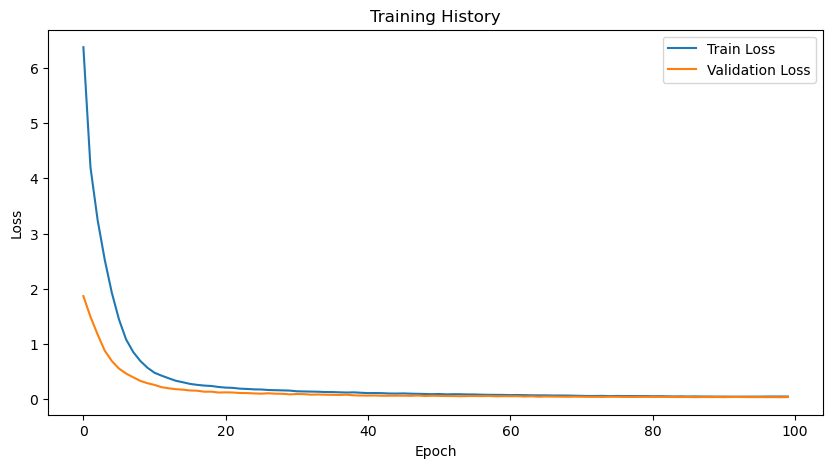


Test Results:
Test Loss: 0.0279
Test Accuracy: 99.08%


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )
        
        self.shortcut = nn.Sequential()
        if in_features != out_features:
            self.shortcut = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features)
            )
    
    def forward(self, x):
        return self.block(x) + self.shortcut(x)

class ComplexFFNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.hidden_sizes = [512, 1024, 2048, 1024, 512, 256, 128]
        self.dropout_rate = 0.3
        
        self.input_block = nn.Sequential(
            nn.Linear(input_size, self.hidden_sizes[0]),
            nn.BatchNorm1d(self.hidden_sizes[0]),
            nn.GELU(),
            nn.Dropout(self.dropout_rate)
        )
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(self.hidden_sizes)-1):
            self.hidden_layers.append(
                ResidualBlock(
                    self.hidden_sizes[i],
                    self.hidden_sizes[i+1],
                    self.dropout_rate
                )
            )
        
        self.output_block = nn.Sequential(
            nn.Linear(self.hidden_sizes[-1], output_size),
            nn.LogSoftmax(dim=1)
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.input_block(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_block(x)

def train_model(model, train_loader, val_loader, num_epochs, device, learning_rate=3e-4):
    model = model.to(device)
    criterion = nn.NLLLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        div_factor=25.0
    )
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    patience = 10
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_losses = []
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device)
                data = data.view(data.size(0), -1)  # Flatten the images
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                epoch_train_losses.append(loss.item())
                pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})
        
        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_epoch_losses = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                data = data.view(data.size(0), -1)  # Flatten the images
                
                output = model(data)
                loss = criterion(output, target)
                val_epoch_losses.append(loss.item())
                
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        avg_val_loss = np.mean(val_epoch_losses)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        print(f'Average Val Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    criterion = nn.NLLLoss()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)  # Flatten the images
            
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    
    return test_loss, accuracy

if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Data loading and preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ])
    
    # Load MNIST Dataset
    train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)
    
    # Split training data into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=256, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=256, num_workers=4, pin_memory=True)
    
    # Initialize model
    model = ComplexFFNN(input_size=784, output_size=10)
    
    # Train model
    num_epochs = 100
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, device)
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_accuracy = evaluate_model(model, test_loader, device)
    print(f'\nTest Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Results:
Test Loss: 0.0305
Test Accuracy: 99.00%


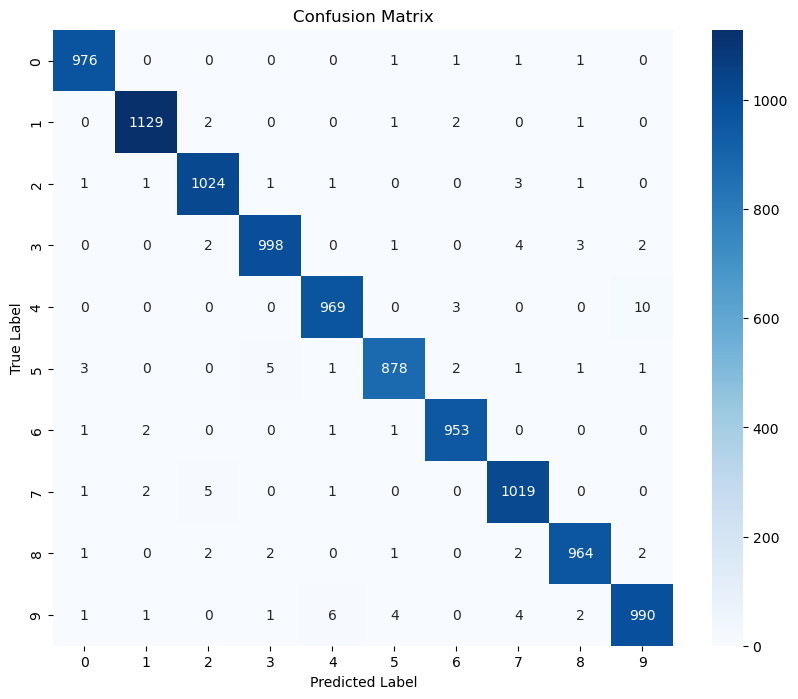


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, device, class_names=None):
    """
    Compute and plot confusion matrix.
    
    Args:
        model: trained PyTorch model
        test_loader: DataLoader containing test data
        device: device to run the model on
        class_names: list of class names (optional)
    """
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)  # Flatten the images
            
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                              target_names=class_names if class_names else None))

if __name__ == "__main__":
    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_accuracy = evaluate_model(model, test_loader, device)
    print(f'\nTest Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    # Plot confusion matrix
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plot_confusion_matrix(model, test_loader, device, class_names)